In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import piezo
import ast
from scipy import stats
import statsmodels.api as sm
import pymc as pm
import arviz as az

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import resample
import json
from protocols.BuildCatalogue import BuildCatalogue



wildcards = {
    "Rv0678@*=": {"pred": "S", "evid": {}},
    "Rv0678@-*_indel": {"pred": "U", "evid": {}},
    "Rv0678@*_indel": {"pred": "U", "evid": {}},
    "Rv0678@-*?": {"pred": "U", "evid": {}},
    "Rv0678@*?": {"pred": "U", "evid": {}},
    "Rv0678@del_0.0": {"pred": "U", "evid": {}},
    "pepQ@*=": {"pred": "S", "evid": {}},
    "pepQ@-*_indel": {"pred": "U", "evid": {}},
    "pepQ@*_indel": {"pred": "U", "evid": {}},
    "pepQ@-*?": {"pred": "U", "evid": {}},
    "pepQ@*?": {"pred": "U", "evid": {}},
    "pepQ@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@*=": {"pred": "S", "evid": {}},
    "mmpS5@-*_indel": {"pred": "U", "evid": {}},
    "mmpS5@*_indel": {"pred": "U", "evid": {}},
    "mmpS5@-*?": {"pred": "U", "evid": {}},
    "mmpS5@*?": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpL5@*=": {"pred": "S", "evid": {}},
    "mmpL5@-*_indel": {"pred": "U", "evid": {}},
    "mmpL5@*_indel": {"pred": "U", "evid": {}},
    "mmpL5@-*?": {"pred": "U", "evid": {}},
    "mmpL5@*?": {"pred": "U", "evid": {}},
    "mmpL5@del_0.0": {"pred": "U", "evid": {}},
    "atpE@*=": {"pred": "S", "evid": {}},
    "atpE@-*_indel": {"pred": "U", "evid": {}},
    "atpE@*_indel": {"pred": "U", "evid": {}},
    "atpE@-*?": {"pred": "U", "evid": {}},
    "atpE@*?": {"pred": "U", "evid": {}},
    "atpE@del_0.0": {"pred": "U", "evid": {}},
}

## Variant aggregation strategies

There are 3 ways to do this. The simplest is just using an exact test, like Fishers or Chi squared. Chi squared will probably be better due to sparse data.

In [3]:
aggregate_rule = piezo.ResistanceCatalogue("./temp/aggregate_rule.csv")
catalogue = pd.read_csv('./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv')

aggregate_vars = []
for i in catalogue.index:
    mutation = catalogue['MUTATION'][i]
    if (mutation != aggregate_rule) and (mutation not in wildcards.keys()):
        if aggregate_rule.predict(mutation)['BDQ'] == 'R':
            aggregate_vars.append(mutation)
            
aggregate_vars

['Rv0678@142_ins_t',
 'Rv0678@192_ins_g',
 'Rv0678@234_ins_t',
 'Rv0678@492_ins_g',
 'Rv0678@212_del_c',
 'Rv0678@372_del_g',
 'Rv0678@345_del_g',
 'Rv0678@492_ins_ga',
 'Rv0678@274_ins_a',
 'Rv0678@30_del_g',
 'Rv0678@394_del_cgaa',
 'Rv0678@14_ins_cggggtg',
 'Rv0678@490_ins_ac',
 'Rv0678@419_del_gggatctgtt',
 'Rv0678@193_del_g',
 'Rv0678@141_ins_c',
 'Rv0678@138_ins_g',
 'Rv0678@465_ins_c',
 'Rv0678@132_ins_gt',
 'Rv0678@471_del_cagc',
 'Rv0678@140_ins_tc',
 'Rv0678@423_ins_c',
 'Rv0678@199_ins_tc',
 'Rv0678@148_ins_g',
 'Rv0678@289_del_c',
 'Rv0678@287_del_g',
 'Rv0678@136_ins_g',
 'Rv0678@150_ins_c',
 'Rv0678@167_del_tggcgacggcgctggcggccagcagcggggggatcagcaccaatgcccggatgctgatccaatttgggttcattgagcggctcgcggtcgccggggatcggcgcacctattt',
 'Rv0678@394_ins_ga',
 'Rv0678@441_ins_t',
 'Rv0678@292_del_a',
 'Rv0678@265_ins_t',
 'Rv0678@383_del_c',
 'Rv0678@433_del_tatatgg',
 'Rv0678@90_ins_a',
 'Rv0678@491_ins_cg',
 'Rv0678@419_del_g',
 'Rv0678@128_del_tgctggtgtgt',
 'Rv0678@369_ins_gc',
 'Rv067

In [4]:
subsample = catalogue[catalogue.MUTATION.isin(aggregate_vars)]
contigency = []
for i in subsample.index:
    evidence = ast.literal_eval(subsample['EVIDENCE'][i])
    contigency.append([evidence['solo_R'], evidence['solo_S']])

contigency

cont_df = {}
for i in range(len(aggregate_vars)):
    cont_df[aggregate_vars[i]] = {'R': contigency[i][0], 'S':contigency[i][1]}


contingency_df = pd.DataFrame(cont_df).T
contingency_df.to_csv('./lof_counts.csv')

In [5]:
stats.chisquare(contigency)

Power_divergenceResult(statistic=array([3315.54545455, 1497.416     ]), pvalue=array([0.00000000e+000, 9.25994297e-273]))

The chisquared value suggests significant heterogeneity in the effects of mutations on the phenotype, and the low p-value indiciates the observed distriubtion of outcomes (R vs S) across different mutations significanty deviates from what would be expected if all mutation shad a unform effect on the phenotype. This would suggest we cannot aggregate to a single R vs S phenotype (and therefore = U).

A limitation of the chi squared test is its inability to accurately consider entities with no low frequencies ( < 5) - and most of our rows are singletons. We could altneratively use a Fisher's test, but to model effect heterogeneity this would mean running an exact test on every pair of mutations and analysis each individual output. An arbitrary consensus threshold could then be applied, but its not a clean, global assessment

### Logistic regression

In [6]:
#prepare input df

solo_dict = {}
for i in range(len(aggregate_vars)):
    solo_dict[aggregate_vars[i]] = contigency[i]

data = []
for mutation, counts in solo_dict.items():
    for _ in range(counts[0]):
        data.append({'Mutation': mutation, 'Outcome': 1}) 
    for _ in range(counts[1]):
        data.append({'Mutation': mutation, 'Outcome': 0}) 

df = pd.DataFrame(data)
df

,Mutation,Outcome
0,Rv0678@142_ins_t,0
1,Rv0678@192_ins_g,1
2,Rv0678@192_ins_g,1
3,Rv0678@192_ins_g,1
4,Rv0678@192_ins_g,1
...,...,...
461,Rv0678@273_ins_a,1
462,Rv0678@426_ins_t,1
463,Rv0678@138_ins_ga,1
464,Rv0678@325_ins_g,1


In [7]:
mutation_dummies = pd.get_dummies(df['Mutation'], drop_first=True)

X = mutation_dummies
X = sm.add_constant(X)

y = df['Outcome']

model = sm.Logit(y, X).fit()

         Current function value: 0.439607
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
mutation_dummies

,Rv0678@125_del_g,Rv0678@128_del_tgctggtgtgt,Rv0678@132_del_gg,Rv0678@132_ins_gt,Rv0678@133_del_gt,Rv0678@136_ins_g,Rv0678@138_ins_g,Rv0678@138_ins_ga,Rv0678@138_ins_gatc,Rv0678@140_ins_tc,...,Rv0678@465_ins_c,Rv0678@466_ins_g,Rv0678@471_del_cagc,Rv0678@490_ins_ac,Rv0678@491_ins_cg,Rv0678@492_ins_g,Rv0678@492_ins_ga,Rv0678@53_del_aa,Rv0678@67_ins_t,Rv0678@90_ins_a
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
463,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Using basic logistic regression has not worked and there is no convergence - likely because we have a lot of fmutations that perfectly predict the phenotype (ie, singletons). The data is also very sparse, with most values being 0 except or a single 1 in each row (because we're working with solos). This can lead to perfect seperation and to infinite likelihood for those coefficients.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#L1 regularisation
model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
model.fit(X_scaled, y)

# Predicting probabilities
probabilities = model.predict_proba(X_scaled)
print("ROC AUC:", roc_auc_score(y, probabilities[:, 1]))

ROC AUC: 0.7895953079178886


In [ ]:
#convert log odds to odds ratios
print (np.exp(model.coef_))

[[1.         1.05253576 1.05253472 1.05253518 0.90592902 1.05253523
  1.2147697  0.77956051 1.05253576 1.05253519 1.         0.81120025
  0.79538376 1.2491692  0.79538207 1.21477202 1.05253302 1.17881166
  1.0525347  0.44463836 0.75522938 1.09943105 1.05253522 0.70582299
  0.70582222 1.05253576 1.14071921 1.05253297 0.89193292 1.09943009
  1.14072208 1.         0.64126499 1.05253519 0.7953846  1.05253523
  1.05253294 1.09942999 0.79538378 1.14072465 0.79538379 1.052533
  0.91827191 1.05253299 0.79538422 1.07176253 1.05253519 1.05253472
  1.05253294 1.05253301 1.14072309 1.1788162  0.94108186 1.05253299
  1.14072455 0.79538207 0.98464058 0.79538206 0.79538215 1.05253621
  1.05253472 1.09942998]]


Ok, so now we have log odds of each mutations - values above 1 support a positive effect (resistance) - gives a measure of strength of effect.    

Let's see if we can confidence intervals for these coefficients:

In [ ]:
def bootstrap_ci(model, X, y, n_iters=1000, ci=95):
    bootstrapped_coefs = np.zeros((n_iters, X.shape[1]))

    for i in range(n_iters):
        X_boot, y_boot = resample(X, y)

        X_boot_scaled = scaler.fit_transform(X_boot)

        model.fit(X_boot_scaled, y_boot)

        bootstrapped_coefs[i] = np.exp(model.coef_[0])

    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    ci_lower = np.percentile(bootstrapped_coefs, lower_percentile, axis=0)
    ci_upper = np.percentile(bootstrapped_coefs, upper_percentile, axis=0)

    mean_coefs = np.mean(bootstrapped_coefs, axis=0)


    return ci_lower, ci_upper, mean_coefs

ci_lower, ci_upper, mean_coefs = bootstrap_ci(model, X, y)

# Example: Print CI for the first coefficient
ci = []
for i in range(len(ci_lower)):
    ci.append([ci_lower[i], ci_upper[i]])


/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[array([0.        , 0.04472926, 0.04238865, 0.04140301, 0.25589134,
       0.04118247, 0.16771708, 0.28779501, 0.04158898, 0.04261289,
       0.26580185, 0.37528982, 0.21960186, 0.18428666, 0.23862849,
       0.16734574, 0.03841962, 0.15396518, 0.04036038, 0.17713197,
       0.20901515, 0.08026589, 0.04094874, 0.21408041, 0.20287017,
       0.04247664, 0.1177536 , 0.04228072, 0.24499961, 0.08123681,
       0.12034941, 0.23631881, 0.17867235, 0.04026006, 0.21423851,
       0.04010902, 0.04061753, 0.08133803, 0.22967403, 0.11666112,
       0.22147174, 0.04205014, 0.23844738, 0.03920674, 0.22947747,
       0.30736059, 0.04092597, 0.04014385, 0.04163012, 0.04116598,
       0.11655033, 0.1521555 , 0.24949085, 0.04195162, 0.1137626 ,
       0.21629442, 0.24919511, 0.23724307, 0.21930351, 0.03973233,
       0.03945864, 0.07967718]), array([0.        , 0.13112648, 0.11828399, 0.11815902, 0.23950974,
       0.10615572, 0.19981178, 0.24955948, 0.12153285, 0.11361328,
       0.53255995, 0.2364807

([<matplotlib.axis.XTick at 0x29e9c9050>,
 [Text(0, 0, 'constant'),
  Text(1, 0, 'Rv0678@125_del_g'),
  Text(2, 0, 'Rv0678@128_del_tgctg'),
  Text(3, 0, 'Rv0678@132_del_gg'),
  Text(4, 0, 'Rv0678@132_ins_gt'),
  Text(5, 0, 'Rv0678@133_del_gt'),
  Text(6, 0, 'Rv0678@136_ins_g'),
  Text(7, 0, 'Rv0678@138_ins_g'),
  Text(8, 0, 'Rv0678@138_ins_ga'),
  Text(9, 0, 'Rv0678@138_ins_gatc'),
  Text(10, 0, 'Rv0678@140_ins_tc'),
  Text(11, 0, 'Rv0678@141_ins_c'),
  Text(12, 0, 'Rv0678@142_ins_t'),
  Text(13, 0, 'Rv0678@148_ins_g'),
  Text(14, 0, 'Rv0678@14_ins_cggggt'),
  Text(15, 0, 'Rv0678@150_ins_c'),
  Text(16, 0, 'Rv0678@167_del_tggcg'),
  Text(17, 0, 'Rv0678@16_del_g'),
  Text(18, 0, 'Rv0678@174_ins_gc'),
  Text(19, 0, 'Rv0678@192_ins_g'),
  Text(20, 0, 'Rv0678@193_del_g'),
  Text(21, 0, 'Rv0678@199_ins_tc'),
  Text(22, 0, 'Rv0678@205_del_accaa'),
  Text(23, 0, 'Rv0678@212_del_c'),
  Text(24, 0, 'Rv0678@234_ins_t'),
  Text(25, 0, 'Rv0678@242_ins_gc'),
  Text(26, 0, 'Rv0678@265_ins_t'),
  Tex

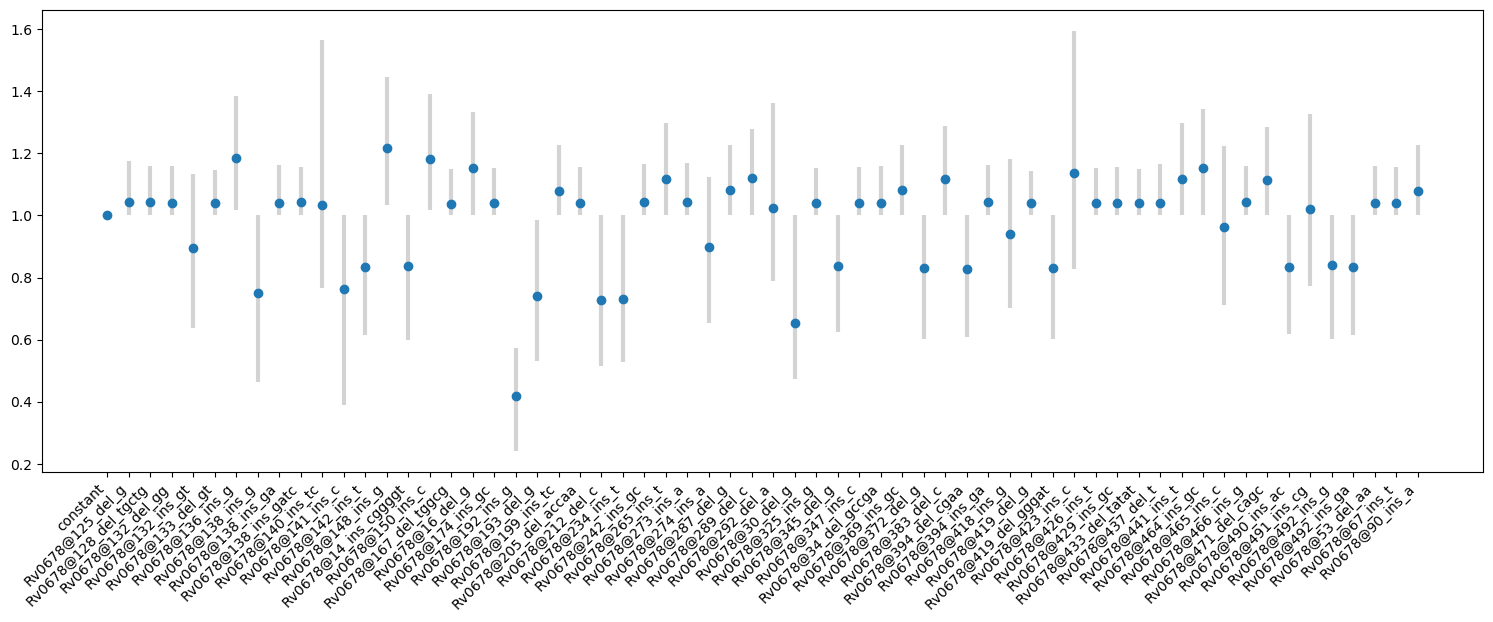

In [ ]:
confidence_sorted = np.sort(ci, axis=1)
lower_confidence = confidence_sorted[:, 0]
upper_confidence = confidence_sorted[:, 1]

x = np.arange(len(model.coef_[0]))
y = mean_coefs

errors = [y - lower_confidence, upper_confidence - y]
#errors = [errors[0], np.abs(errors[1])]
print (errors)


plt.figure(figsize=(len(x) * 0.3, 6))  

sns.scatterplot(x=x, y=y)
plt.errorbar(x=x, y=y, yerr=errors, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0)

xticks = ['constant'] + [i if len(i) <= 20 else i[:20] for i in mutation_dummies.columns]

plt.xticks(x, xticks, rotation=45, ha="right")  # Adjust rotation and alignment as needed


Ok, our estimates of the coefficients are very imprecise, and most hit zero - suggesting no significant association with resistance. The effect sizes are also small. Therefore, aggregating mutations and running a fishers test rejects the null, but individual logistic regression coefficients are not significant. 

Logistic regression analysis of individual mutations requires more statistical power to detect a significant effect for each mutation, especially if the effect sizes are small or the sample size is limited. In contrast, aggregating mutations into a single variable for Fisher's test might increase the power to detect an association by simplifying the analysis to a binary comparison.

The sample size and the variability of the mutations across the samples can also influence the ability to detect significant effects. Aggregation can sometimes mitigate issues with sparse data for individual categories.

These singletons and limited data are really limitng the power of the logistic regression model.

Bayesian methods, on the other hand, allow for shrinkage - pulling estimates for groups with little data (like singletons) towards the overall mean. This "borrowing strength" from the entire dataset helps stabilize estimates for mutations with very few observations.

Therefore, lets try that.

## Bayesian Mixed Model

We want a  hierichichal bayesian model where effect size for loss of functions in a particular gene is modeled, as well as the heterogeneity in effect size within the gene.

### Generate priors


We need a prior effect size distribution and measure of heterogeneity. One option is to calculate mean effect size of loss (mean log(odds_ratio)) of mutations in other genes, and use the standard deviation of the mean effect size as the variance prior.   

Question - we would be picking genes we know are relevant, and therefore would be assuming LOFs in those genes are resistant - but then that's also what we're testing....? Linked to this, do we calculcate heterogeneity in other genes only (ie not include Rv0678)?

One way to calculate a useful prior would be to assess heterogeneity of outcomes across genes that contain R-relevant LOFs. To do this, lets use the WHO's assessment of relevant genes, and read in their solos contigency tables.   

Genes with R lof in WHOv2:
Rv0678 (BDQ)   
pepQ (BDQ)   
katG (INH)   
pncA (PZA)   
ddn (DLM)   
fbiC (DLM)   
fbiA (DLM)   
fgd1 (DLM)   
fbiB (DLM)   
Rv2983 (DLM)   
gid (STM)  
ethA (ETO)   

In [214]:
lof_genes = {'BDQ':['Rv0678', 'pepQ'], 'INH':['katG'], 'DLM':['ddn', 'fbiC', 'fbiA', 'fbiB',], 'STM':['gid'], 'ETH':['ethA']}
rules = ['*_fs', '*!']

aggregate_vars = {}

for drug, genes in lof_genes.items():

    catalogue = pd.read_csv(f"../../tb-cat-builder/catalogues/{drug}_FRS_0.25.csv")
    with open(f'../../tb-cat-builder/wildcards/{drug.lower()}_wildcards.json', 'r') as f:
        wildcards = json.load(f)

    for gene in genes:
        print (gene)
        for rule in rules:
            aggregate_rule = piezo.ResistanceCatalogue(f"./temp/{drug}_{gene}@{rule}.csv")

            for i in catalogue.index:
                mutation = catalogue['MUTATION'][i]

                if (mutation != aggregate_rule) and (mutation not in wildcards.keys()):
                    if aggregate_rule.predict(mutation)[drug] == 'R':
                        evidence = ast.literal_eval(catalogue['EVIDENCE'][i])
                        aggregate_vars[mutation] = [evidence['solo_R'], evidence['solo_S'], evidence['background_R'], evidence['background_S']]

cont_df = {}
for mut, ev in aggregate_vars.items():
    cont_df[mut] = {'R': ev[0], 'S':ev[1], "'R": ev[2], "'S":ev[3], 'n_total':ev[0]+ev[1]}

contingency_df = pd.DataFrame(cont_df).T
contingency_df['Gene'] = [i.split('@')[0] for i in contingency_df.index]

def extract_position(mutation):
    parts = mutation.split('@')[1] 
    position = ''.join(filter(str.isdigit, parts.split('_')[0]))
    return int(position)

contingency_df['Position'] = contingency_df.index.map(extract_position)
contingency_df = contingency_df.sort_values(by='Position')

contingency_df



Rv0678


pepQ
katG
ddn
fbiC
fbiA
fbiB
gid
ethA


,R,S,'R,'S,n_total,Gene,Position
Rv0678@1_ins_t,1,0,251,12740,1,Rv0678,1
ddn@6_ins_aaatc,1,0,99,11788,1,ddn,6
ethA@8_del_a,0,1,1626,12558,1,ethA,8
ethA@12_del_cctcgacgttgtcatcgtgggcgctggaatctccggtgtcagcgcggcctggcacctgcagg,0,1,1166,10912,1,ethA,12
Rv0678@13_del_gacggggtcga,0,1,251,12721,1,Rv0678,13
...,...,...,...,...,...,...,...
katG@2083_ins_cgtgg,1,0,1658,16100,1,katG,2083
katG@2086_del_c,1,0,1658,16100,1,katG,2086
katG@2185_del_g,1,0,1658,16100,1,katG,2185
fbiC@2546_ins_cacatacgccctgcttgcg,0,3,90,10877,3,fbiC,2546


In [215]:
contingency_df.Gene.unique()

array(['Rv0678', 'ddn', 'ethA', 'katG', 'gid', 'pepQ', 'fbiC'],
      dtype=object)

In [120]:
gene = 'Rv0678'
odds_ratios = []
for i in contingency_df[contingency_df.Gene!=gene].index:
    if np.sum([contingency_df['R'][i], contingency_df['S'][i]]):
        # need to additive continuity correction to avoid any 'zero' cells
        odds_ratios.append(((contingency_df['R'][i]+0.5)*(contingency_df["'S"][i]+0.5))/((contingency_df['S'][i]+0.5)*(contingency_df["'R"][i]+0.5)))

mean_odds_ratio = np.mean(np.log(odds_ratios))
std_odds_ratio = np.std(np.log(odds_ratios))
print (mean_odds_ratio, std_odds_ratio)


2.7487186940711914 1.2532330962440994


In [209]:
np.log(odds_ratios)

array([ 5.02371047e+00,  5.87333440e+00,  9.45354972e-01,  1.13728882e+00,
        2.82499348e+00,  3.12085422e+00,  6.32299346e+00,  5.87333440e+00,
        3.64589750e+00,  5.02371047e+00,  1.90586385e+00,  3.12085422e+00,
        3.13507188e+00,  3.64589750e+00,  3.13507188e+00,  3.85177400e+00,
        4.36259962e+00,  3.07780032e+00,  3.64589750e+00,  3.64589750e+00,
        5.02371047e+00,  1.63831548e+00,  4.21946651e+00,  3.13882419e+00,
        2.75316171e+00,  2.14379836e+00,  4.36259962e+00,  5.53453610e+00,
        2.88375745e+00,  3.34094837e+00,  3.85177400e+00,  2.14379836e+00,
        4.69907186e+00,  2.14379836e+00,  3.64589750e+00,  2.14379836e+00,
        5.02371047e+00,  5.02371047e+00,  5.02371047e+00,  3.13507188e+00,
        4.36259962e+00,  3.13507188e+00,  3.13507188e+00,  2.03645959e+00,
        4.23368417e+00,  5.02371047e+00,  1.52563397e+00,  2.14379836e+00,
        3.13507188e+00,  5.31811106e+00,  5.02371047e+00,  2.14379836e+00,
        3.69048958e+00,  

### Build model

In [181]:
df = contingency_df[contingency_df.Gene==gene].reset_index().rename(columns={'index':'Mutation'})

with pm.Model() as model:
    #Defines a normal prior for the mean log odds ratio of mutations. 
    #mean_odds_ratio and std_odds_ratio are calculated from other genes, providing an expectation (mean) and uncertainty (standard deviation) for the effect size of mutations.
    mean_log_odds = pm.Normal('mean_log_odds', mean_odds_ratio, sigma=std_odds_ratio)
    #Sets up a HalfNormal prior for the variance in mutation effects. 
    #The std_odds_ratio here specifies the scale of the distribution, reflecting uncertainty about the variance based on other genes.
    variance = pm.HalfNormal('variance', sigma=std_odds_ratio)
    #This line models the individual effects of each mutation. It assumes a normal distribution for each mutation effect, centered around mean_log_odds with variance variance. 
    #The shape parameter ensures a separate effect size is estimated for each unique mutation.
    mutation_effects = pm.Normal('mutation_effects', mu=mean_log_odds, sigma=pm.math.sqrt(variance), shape=df.Mutation.nunique())

    mutation_idx = df['Mutation'].map({mutation: idx for idx, mutation in enumerate(df.Mutation.unique().tolist())})
    #converts the mutation effects from log-odds to probabilities using the inverse logit function
    p = pm.math.invlogit(mutation_effects[mutation_idx])
    #Defines the likelihood of the data given the model. It models the observed mutation counts as binomial outcomes, with n_total trials and success probabilities p. 
    #This is the core of the model, linking the mutation effects to the observed data.
    likelihood = pm.Binomial('likelihood', n=df['n_total'], p=p, observed=df['R'])

with model:
    trace = pm.sample(1000, tune=2000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_log_odds, variance, mutation_effects]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


In [183]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [122]:
mean_effect = trace['posterior']['mean_log_odds'].mean()
mean_effect

<xarray.DataArray 'mean_log_odds' ()> Size: 8B
array(1.47760858)

<Axes: title={'center': 'mean_log_odds'}>

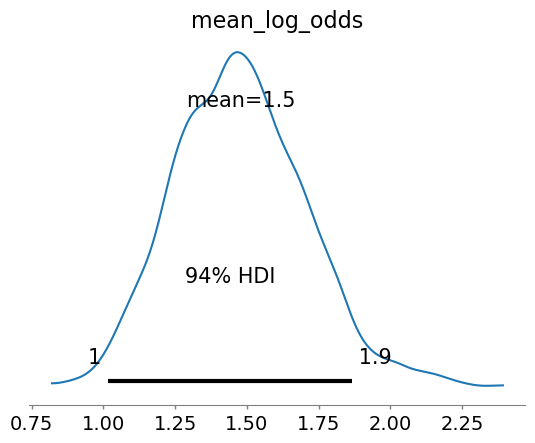

In [123]:
az.plot_posterior(trace, var_names=['mean_log_odds'])

In [124]:
heterogeneity = trace['posterior']['variance'].mean()
heterogeneity

<xarray.DataArray 'variance' ()> Size: 8B
array(1.1061253)

In [136]:
print (heterogeneity)

<xarray.DataArray 'variance' ()> Size: 8B
array(1.1061253)


<Axes: title={'center': 'variance'}>

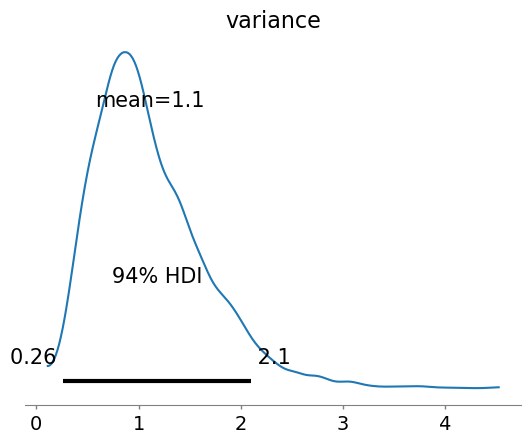

In [125]:
az.plot_posterior(trace, var_names=['variance'])


/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


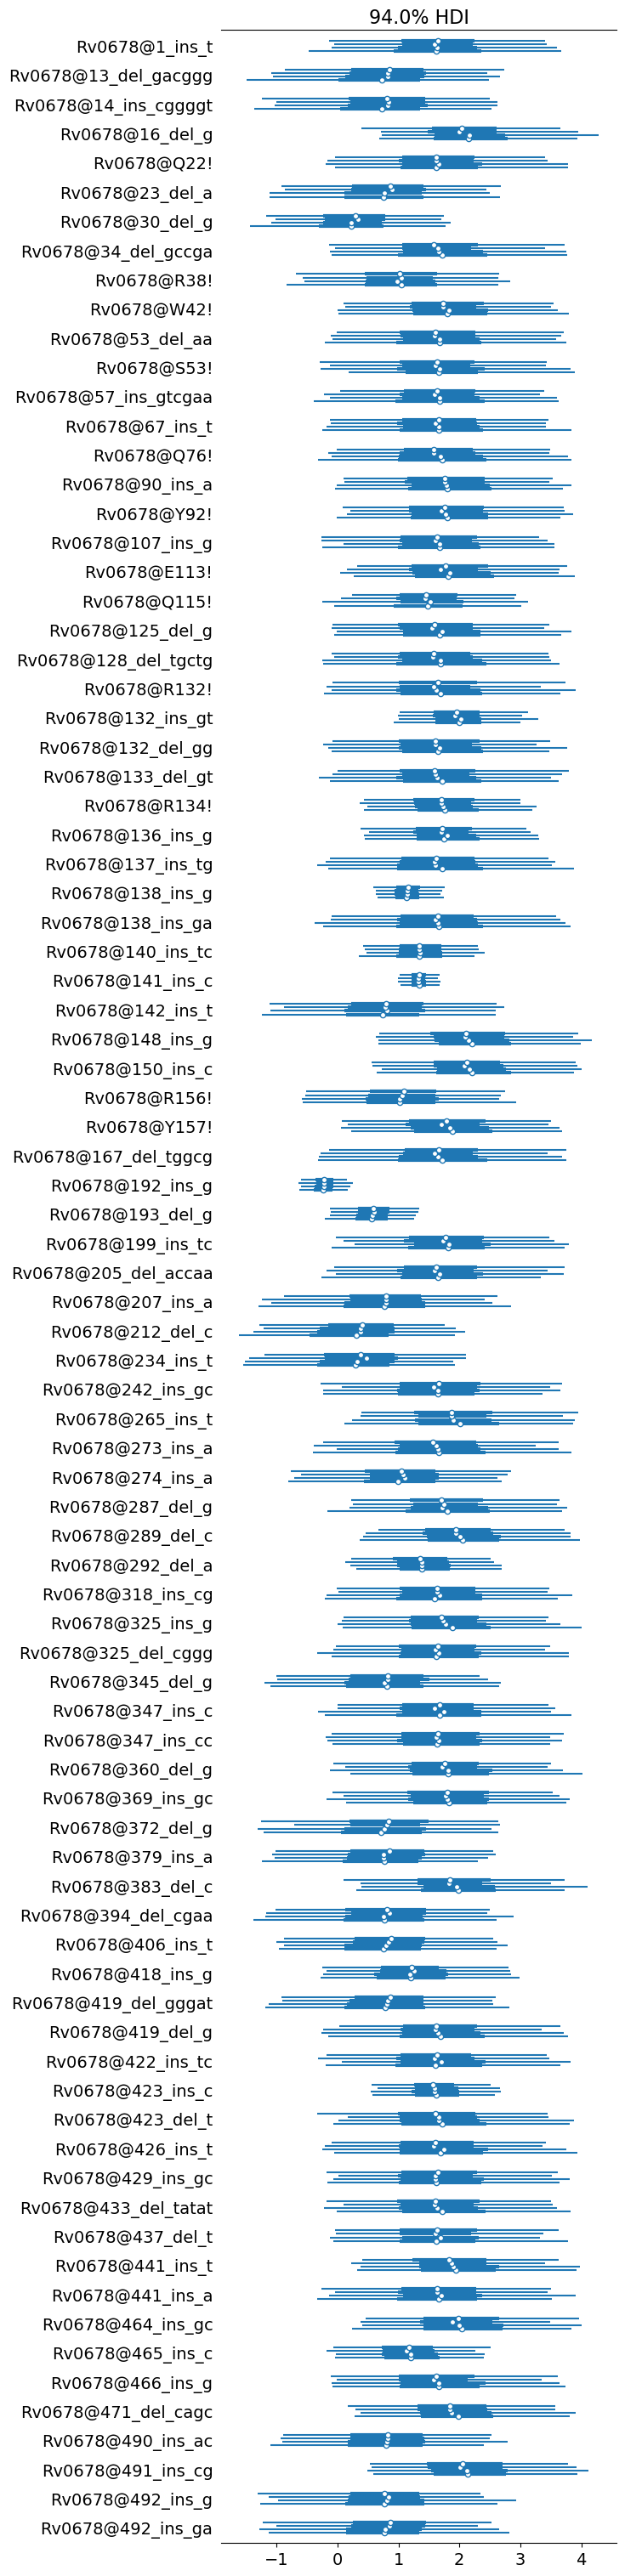

In [126]:
axes = az.plot_forest(trace, var_names=['mutation_effects'])
ax = axes[0] 
ax.set_yticklabels(reversed([i if len(i) <= 20 else i[:20] for i in df.Mutation.unique()]), rotation=0)
plt.show()

In [139]:
contingency_df[contingency_df.index=='Rv0678@193_del_g']

,R,S,'R,'S,n_total,Gene,Position
Rv0678@193_del_g,15,10,251,12740,25,Rv0678,193


### Let's see what this looks like for other genes

In [184]:
traces = {}

for gene in contingency_df.Gene.unique():
    odds_ratios = []
    for i in contingency_df[contingency_df.Gene != gene].index:
        if np.sum([contingency_df["R"][i], contingency_df["S"][i]]):
            # need to additive continuity correction to avoid any 'zero' cells
            odds_ratios.append(
                ((contingency_df["R"][i] + 0.5) * (contingency_df["'S"][i] + 0.5))
                / ((contingency_df["S"][i] + 0.5) * (contingency_df["'R"][i] + 0.5))
            )

    mean_odds_ratio = np.mean(np.log(odds_ratios))
    std_odds_ratio = np.std(np.log(odds_ratios))

    df = (
        contingency_df[contingency_df.Gene == gene]
        .reset_index()
        .rename(columns={"index": "Mutation"})
    )

    with pm.Model() as model:
        mean_log_odds = pm.Normal(
            "mean_log_odds", mean_odds_ratio, sigma=std_odds_ratio
        )
        variance = pm.HalfNormal("variance", sigma=std_odds_ratio)

        mutation_effects = pm.Normal(
            "mutation_effects",
            mu=mean_log_odds,
            sigma=pm.math.sqrt(variance),
            shape=df.Mutation.nunique(),
        )

        mutation_idx = df["Mutation"].map(
            {
                mutation: idx
                for idx, mutation in enumerate(df.Mutation.unique().tolist())
            }
        )

        p = pm.math.invlogit(mutation_effects[mutation_idx])
        likelihood = pm.Binomial("likelihood", n=df["n_total"], p=p, observed=df["R"])

    with model:
        trace = pm.sample(1000, tune=2000, target_accept=0.95)

    traces[gene] = {
        "prior": {"mean_log_odds": mean_odds_ratio, "variance": std_odds_ratio},
        "posterior": {
            "mean_log_odds": trace["posterior"]["mean_log_odds"].mean().item(),
            "variance": trace["posterior"]["variance"].mean().item(),
        },
    }


traces

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_log_odds, variance, mutation_effects]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_log_odds, variance, mutation_effects]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_log_odds, variance, mutation_effects]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_log_odds, variance, mutation_effects]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_log_odds, variance, mutation_effects]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_log_odds, variance, mutation_effects]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


{'Rv0678': {'prior': {'mean_log_odds': 2.7487186940711914,
   'variance': 1.2532330962440994},
  'posterior': {'mean_log_odds': 1.4689332796631933,
   'variance': 1.0932143529484801}},
 'ddn': {'prior': {'mean_log_odds': 3.0514840199938273,
   'variance': 1.3995948954534643},
  'posterior': {'mean_log_odds': 2.0473256214932194,
   'variance': 1.3893673314722668}},
 'ethA': {'prior': {'mean_log_odds': 4.062533201531529,
   'variance': 1.2944391091353342},
  'posterior': {'mean_log_odds': 0.7567996823423969,
   'variance': 2.2400700432960257}},
 'gid': {'prior': {'mean_log_odds': 3.0981617527066216,
   'variance': 1.5197121208672797},
  'posterior': {'mean_log_odds': 0.4239571713031194,
   'variance': 0.3830718840293381}},
 'pepQ': {'prior': {'mean_log_odds': 3.077223380312706,
   'variance': 1.4371163499820874},
  'posterior': {'mean_log_odds': 0.8713893417378483,
   'variance': 1.1492649088478277}},
 'fbiC': {'prior': {'mean_log_odds': 3.1055455788363457,
   'variance': 1.4414126536453

In [185]:
results = traces.copy()
rows = []
for gene, stats in results.items():
    row = {'gene': gene}
    for stat_type, values in stats.items():
        for key, value in values.items():
            row[f'{stat_type}_{key}'] = value
    rows.append(row)

# Convert to DataFrame
df = pd.DataFrame(rows)
df

,gene,prior_mean_log_odds,prior_variance,posterior_mean_log_odds,posterior_variance
0,Rv0678,2.748719,1.253233,1.468933,1.093214
1,ddn,3.051484,1.399595,2.047326,1.389367
2,ethA,4.062533,1.294439,0.756800,2.240070
3,gid,3.098162,1.519712,0.423957,0.383072
4,pepQ,3.077223,1.437116,0.871389,1.149265
5,fbiC,3.105546,1.441413,-0.015632,1.507328


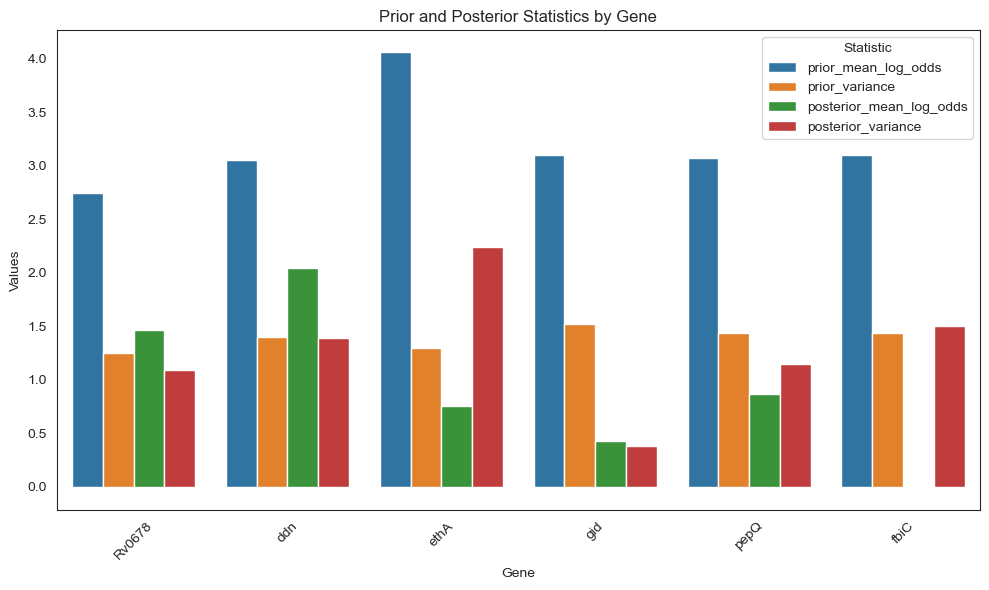

In [186]:
df_long = pd.melt(df, id_vars=['gene'], var_name='statistic', value_name='value')

# Creating the plot
sns.set_style('white')
plt.figure(figsize=(10, 6))

# Using catplot to create a bar plot with multiple bars per category
sns.barplot(data=df_long, x='gene', y='value', hue='statistic')

plt.xlabel('Gene')
plt.ylabel('Values')
plt.title('Prior and Posterior Statistics by Gene')
plt.xticks(rotation=45)
plt.legend(title='Statistic', loc='best')


plt.tight_layout()
plt.show()


In [179]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [217]:
contingency_df

,R,S,'R,'S,n_total,Gene,Position
Rv0678@1_ins_t,1,0,251,12740,1,Rv0678,1
ddn@6_ins_aaatc,1,0,99,11788,1,ddn,6
ethA@8_del_a,0,1,1626,12558,1,ethA,8
ethA@12_del_cctcgacgttgtcatcgtgggcgctggaatctccggtgtcagcgcggcctggcacctgcagg,0,1,1166,10912,1,ethA,12
Rv0678@13_del_gacggggtcga,0,1,251,12721,1,Rv0678,13
...,...,...,...,...,...,...,...
katG@2083_ins_cgtgg,1,0,1658,16100,1,katG,2083
katG@2086_del_c,1,0,1658,16100,1,katG,2086
katG@2185_del_g,1,0,1658,16100,1,katG,2185
fbiC@2546_ins_cacatacgccctgcttgcg,0,3,90,10877,3,fbiC,2546


In [216]:
contingency_df.sort_values(by=['Gene', 'Position'], ascending=True)[['R', 'S', 'n_total', 'Gene', 'Position']].to_csv('lof_counts.csv')

In [211]:
#determine true background rantes for each gene

mutations = pd.read_pickle('../cryptic-tables-v2.1.1/MUTATIONS.pkl.gz')
phenotypes = pd.read_pickle('./data/crypticv2.1.1/DST_MEASUREMENTS.pkl.gz')

In [ ]:
{ "INH": {"genes": ["inhA", "katG", 'fabG1'], "seed": {}},
    "BDQ": {"genes": ["Rv0678", "pepQ", "atpE"], "seed": {}},
     "STM": {"genes": ["rrs", "gid", "rpsL"], "seed": {}},
     "DLM": {"genes": ["ddn", "fbiA", "fbiC", "fbiB"], "seed": {}},
    "ETH": {"genes": ["inhA", "ethA"], "seed": {}},
}